
<h3>PoC: End-to-end Machine Learning project</h3>
    Dataset: Boston housing price kaggle, available <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/housing/"> here </a>

### Steps getting involved: 
1. Load required libraries 
2. Load the dataset
3. Descriptive statistics summarization 
4. Visualization 
5. Data pre-processing and Transformation 
6. Modeling using CART 
    - ML model setup and default parameter settings 
    - Cross validation setup 
    - Training 
    - Evaluation 
    - Saving model 
7. Prediction



In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import time
import itertools
import pandas as pd 
import pickle as pk 
import numpy as np  
import seaborn as sns 
import matplotlib.pyplot as plt 
import sklearn as sk
sns.set_context('talk')
sns.set_style('darkgrid', {'font.sans-serif': ['Iosevka']})

print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Sklearn version: {sk.__version__}")

Pandas version: 1.1.0
Numpy version: 1.19.1
Seaborn version: 0.10.1
Sklearn version: 0.23.2


In [3]:
# Global variable 
train_file = 'datasets/housing.data'
test_file = 'datasets/housing.data'

In [4]:
def load_dataset(filename):
    features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    target = 'MEDV'
    dataset = pd.read_csv(train_file, header=None, delimiter=r"\s+", names=features)
    print(f"+ Dataset:")
    display(dataset.head(3))
    print(f"+ Shape: \n{dataset.shape} \n") 
    print(f"+ Info: ")
    print(f"{dataset.info(memory_usage='deep')}")
    return features, target, dataset

features, target, dataset = load_dataset(train_file)

+ Dataset:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7


+ Shape: 
(506, 14) 

+ Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None


<div style="font-family:'Barlow';font-size:20px;">
<h3>Descriptive statistics summarization </h3>
</div>

In [5]:
# Get set of redundant pairs 
def select_redundant_pairs(dataset):
    df = dataset.copy()
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# Top n Pairwise Correlation of features 
def get_topn_corr_pairs(dataset, n=5):
    df = dataset.copy()
    corr = df.corr().abs().unstack()
    corr = corr.drop(labels=select_redundant_pairs(df)).sort_values(ascending=False)
    return corr[:n]

# Highly correlated cols pairs(decided by a threshold: th)   
def get_corr_pairs(dataset, th=.8):
    df = dataset.copy()
    X = [[(c1, c2), df.corr().abs().loc[c1, c2]] for 
           c1, c2 in list(itertools.combinations(df.columns, 2))]
    df = pd.DataFrame(X, columns=['pairs', 'correlation'])
    df = df[df.correlation > th]
    df = df.sort_values(by='correlation', ascending=False)
    return df

# Slightly correlated features to the target(decided by a threshold: th)   
def get_corr_features(dataset, target, th=0.0):
    df = dataset.copy()
    corr = abs(df.corr().drop(target)[target]).sort_values(ascending=False)
    cols_to_drop = df.corr()[target][abs(df.corr()[target]) <= th].index.tolist()
#     df.drop(columns=cols_to_drop, inplace=True)
    return corr, cols_to_drop

# Remove constant cols based low variability threshold(applied to numeric variable)
def filter_const_cols(dataset, th=0.0):
    df = dataset.copy()
    df = df.select_dtypes(include=['number'])
    var = df.var().sort_values(ascending=False)
    cols_to_drop = df.var()[df.var() <= th].index.tolist()
#     df.drop(columns=cols_to_drop, inplace=True)
    return var, cols_to_drop

# Remove sparse cols or features with 1 level/category(applied to categorical variable)
def filter_sparse_cols(dataset, features, target):
    df = dataset.copy()
    df = df.select_dtypes(include=['object'])
    if df.empty:
        return None, dataset
    
    flist = [x for x in df.columns if not x in target]
    sparse_cols = list()
    if flist:
        for col in flist:
            if len(np.unique(df[col])) < 2:
                df.drop(col, axis=1, inplace=True)
                sparse_cols.append(col)
        return sparse_cols, df
    return None, df

# Remove duplicated cols 
def remove_duplicated_cols(dataset):
    df = dataset.copy()
    # Figure out duplicates by col_name 
    dup_cols = pd.Series(df.columns).value_counts()[lambda x: x>1]
    if dup_cols.empty:
        dup_cols = None 
    else:
        df.drop(dup_cols.index, axis=1, inplace=True)    
    # Drop duplicates by column values  
    df = df.T.drop_duplicates().T
    return dup_cols, df 


In [6]:
def summary_stat(dataset, feature, target):
    # Get top 10 pairwise correlated features
    print(f"+ Top 10 pairwise correlated features: \n{get_topn_corr_pairs(dataset,10)}\n")
    # Pairs of features highly correlated at th(less useful)
    print(f"+ Pairs of features highly correlated | corr > th:0.8 :\n{get_corr_pairs(dataset, 0.8)}\n")
    # Features slightly correlated to the target at th(less useful)
    corr, cols_to_drop = get_corr_features(dataset, target, 0.2)
    print(f"+ Correlation bw features and target: \n{corr}\n")
    print(f"+ Features slightly correlated to the target | corr <= th:0.2 :\n{cols_to_drop}\n")
    # Filter low variable columns(less useful)
    var, cols_to_drop = filter_const_cols(dataset, 0.5)
    print(f"+ Features variance: \n{var}\n")
    print(f"+ Features slightly variable | var < 1: \n{cols_to_drop}\n")
    # Filter sparse cols 
    sparse_cols, df = filter_sparse_cols(dataset, features, target)
    print(f"+ Sparse features: \n{sparse_cols}\n")
    print(f"+ Data without sparse features:")
    display(df.head(3))
    # Remove duplicated cols by col name and col values 
    dup_cols, df = remove_duplicated_cols(dataset)
    print(f"+ Suspicious duplicated cols by names or column values: \n{dup_cols}\n")
    print(f"+ Data without duplicated features:")
    display(df.head(3))
    # Target information 
    print(f"+ Statistics of the target {target}: \n{dataset[target].describe()}\n")
    print(f"+ Target unique values:") # Similar to unique()
    display(dataset.groupby(by=target, dropna=False).size().head(10))
    
    
summary_stat(dataset, features, target)

+ Top 10 pairwise correlated features: 
RAD    TAX     0.910228
NOX    DIS     0.769230
INDUS  NOX     0.763651
AGE    DIS     0.747881
LSTAT  MEDV    0.737663
NOX    AGE     0.731470
INDUS  TAX     0.720760
       DIS     0.708027
RM     MEDV    0.695360
NOX    TAX     0.668023
dtype: float64

+ Pairs of features highly correlated | corr > th:0.8 :
         pairs  correlation
76  (RAD, TAX)     0.910228

+ Correlation bw features and target: 
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: MEDV, dtype: float64

+ Features slightly correlated to the target | corr <= th:0.2 :
['CHAS']

+ Features variance: 
TAX        28404.759488
B           8334.752263
AGE          792.358399
ZN           543.936814
MEDV          84.586724
RAD           75.816366
CRIM          73.986578


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7


+ Suspicious duplicated cols by names or column values: 
None

+ Data without duplicated features:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


+ Statistics of the target MEDV: 
count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

+ Target unique values:


MEDV
5.0    2
5.6    1
6.3    1
7.0    2
7.2    3
7.4    1
7.5    1
8.1    1
8.3    2
8.4    2
dtype: int64

In [7]:
# Missing values summary 
def find_missing_values(dataset, features, target):
    percent_missing = (dataset[features].isnull().sum() / len(dataset) * 100).round(4)
    missing = pd.DataFrame({'column_name': features, 'percent_missing': percent_missing})
    missing.sort_values('percent_missing', ascending=False, inplace=True)
    missing.reset_index(drop=True, inplace=True)
    return missing

In [8]:
def summary_missing(dataset: pd.DataFrame, 
                    features: list, 
                    target: str) -> None:
    # Get summary of the missing values 
    print(f"+ Information on missing data: \n{find_missing_values(dataset, features, target)}\n")

summary_missing(dataset, features, target)

+ Information on missing data: 
   column_name  percent_missing
0         CRIM              0.0
1           ZN              0.0
2        INDUS              0.0
3         CHAS              0.0
4          NOX              0.0
5           RM              0.0
6          AGE              0.0
7          DIS              0.0
8          RAD              0.0
9          TAX              0.0
10     PTRATIO              0.0
11           B              0.0
12       LSTAT              0.0
13        MEDV              0.0



<div style="font-family:'Barlow';font-size:20px;">
<h3>Dummy imputer and encoder used for visualization purposes </h3>
</div>

In [9]:
# Dummy imputer and Encoder are used only for visualization purpose
# Dummy imputer  
def impute_missing(dataset):
    df = dataset.copy()
    for col in df.columns:
        if df[col].dtypes == 'int64':
            df[col] = df[col].fillna(0)
        if df[col].dtypes == 'float64':
            df[col] = df[col].fillna(0.0)
        if df[col].dtypes == 'object':
            df[col] = df[col].fillna('Unkown')
    return df 

# Dummy Encoder 
def dummy_encode(dataset):
    df = dataset.copy()
    cols_to_enc = list(df.select_dtypes(include=['category', 'object']))
    lbl_enc = LabelEncoder()
    for col in cols_to_enc:
        try:
            df[col] = lbl_enc.fit_transform(df[col])
        except:
            print(f"Encoding error `{col}`")
    return df

In [10]:
# Dist plot 
def visualize_dist(df):
    num_cols = list(df.select_dtypes(include=['float64', 'int64']))
    cols = 2
    rows = (len(num_cols) // cols) 
    if (len(num_cols) % cols) != 0:
        rows += 1
    fig, axis = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    fig.tight_layout(w_pad=2, h_pad=2) 
    for i, col in enumerate(num_cols):
        row = i // cols
        pos = i % cols
        _ = sns.distplot(df[col], ax=axis[row][pos], kde=True, color='navy')
        _ = axis[row][pos].set_title('')
        _ = axis[row][pos].set_xlabel(f'{col}', fontdict={'size': 16})
        _ = axis[row][pos].set_ylabel('')
    plt.show()

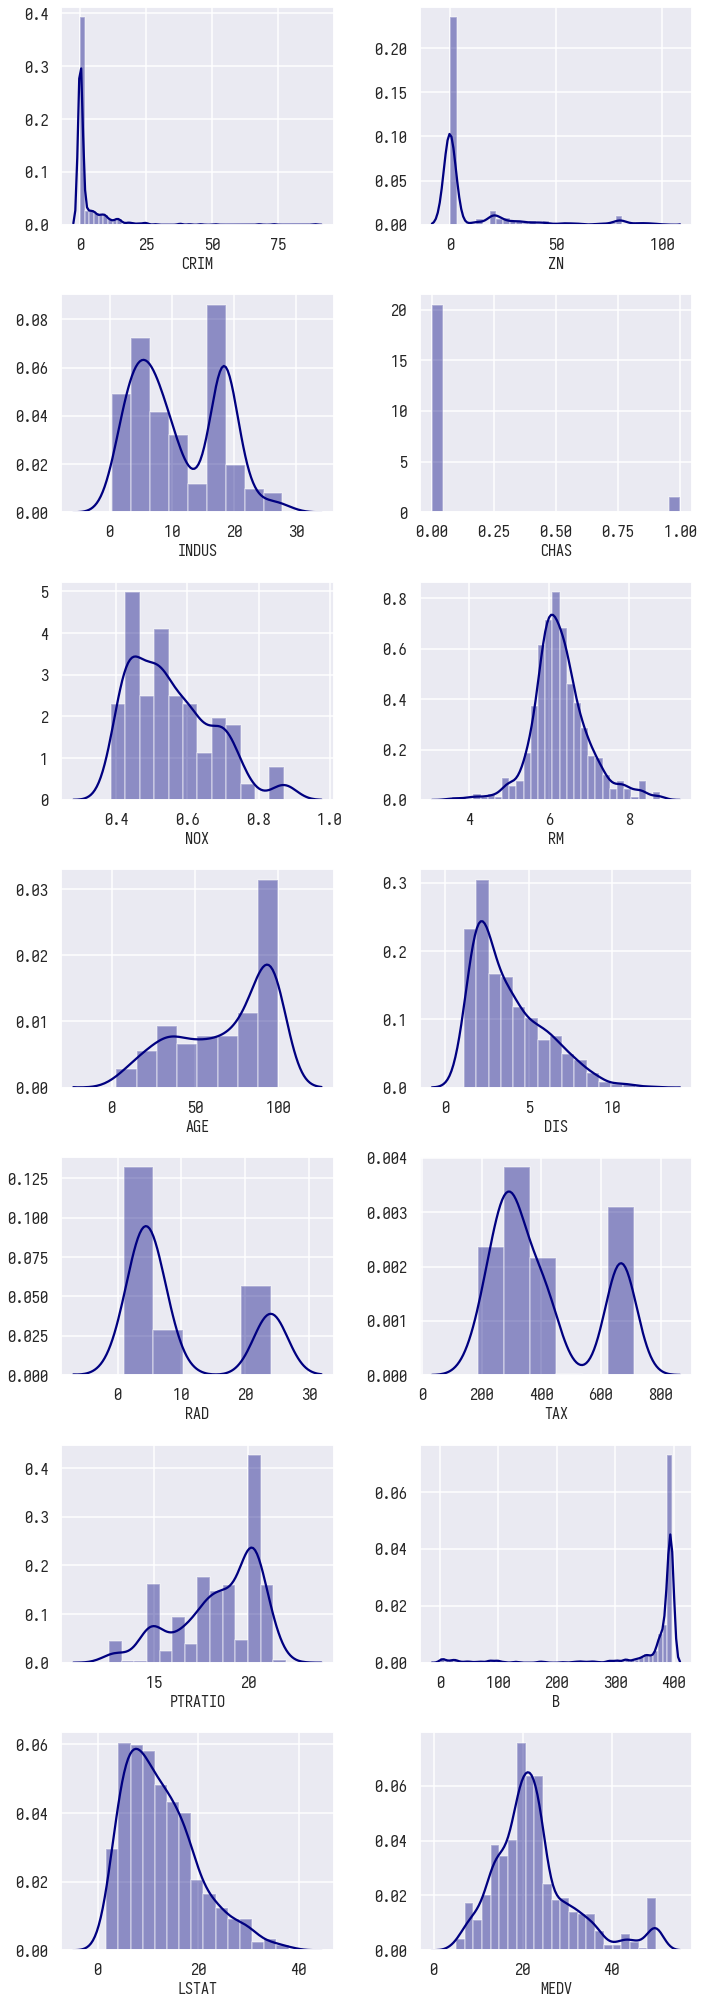

In [11]:
visualize_dist(dataset)

In [12]:
# Correlation Plot 
def visualize_corr(df):
    corr = df.corr()
    # mask for upper right 
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # fig 
    fig, ax = plt.subplots(figsize=(10, 8))
    # custom diverging cmap 
    cmap = sns.diverging_palette(10, 220, as_cmap = True)
    cbar_kws = {"orientation":"vertical", 
                "shrink":1,
                'extend':'min', 
                'extendfrac':0.1, 
               }
    annot_kws={'fontsize':12} 
    # heatmap with the mask and the correct aspect ratio 
    sns.heatmap(corr, mask=mask, cmap=cmap, 
                vmax=1.0, vmin=-1.0, center=0, 
                square=True, linewidths=.5, cbar_kws=cbar_kws)
    plt.show()    

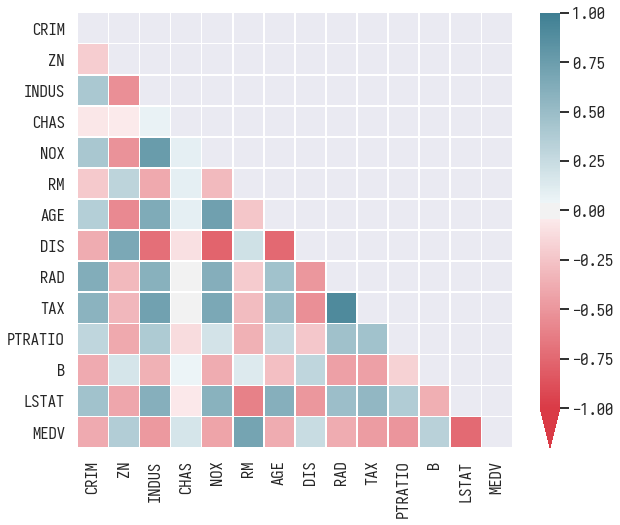

In [13]:
visualize_corr(dataset)

In [14]:
import scikitplot as skplt
import sklearn as sk  
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, ElasticNetCV, LassoCV, RidgeCV, TweedieRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor # This is for stacking part, works well with sklearn and others...
from sklearn.metrics import make_scorer, r2_score, mean_squared_error


In [15]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop([target], axis=1), 
                                                    dataset[target], test_size=.2, random_state=42)

In [16]:
# Select Numerical Var.
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Num. Transformation
num_pipe = Pipeline(
    steps=[
        ('scale', RobustScaler()),
    ])
# Combine Transformation
preprocessor = ColumnTransformer(
    transformers=[
        ('num_trans', num_pipe, num_cols),
    ])

lr_model = LinearRegression()

model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('lr_model', lr_model),
    ])
_ = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Linear Reg:")
print(f"R^2 : {np.sqrt(r2_score(y_test, y_pred)).round(4)}")  
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)).round(4)}")


Linear Reg:
R^2 : 0.8178
RMSE: 4.9286


In [22]:

def preprocess(estimators, X, y):
    # Hyper parameters 
#     alpha_ridge = [15.5, 15.6, 15.7, 15.8, 15.9]
#     alpha_lasso = [0.0005, 0.0006, 0.0007, 0.0008]
    # Select Numerical Var.
    num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    # Num. Transformation
    num_pipe = Pipeline(
        steps=[
            ('scale', RobustScaler()),
        ])
    # Combine Transformation(Cat + Num)
    preprocessor = ColumnTransformer(
        transformers=[
            ('proc_num', num_pipe, num_cols),
        ])
    
    estimators_pipe = dict()
    for name, estimator in estimators.items():
        pipeline = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                (name, estimator),
            ])
        estimators_pipe[name] = pipeline
        
    return estimators_pipe


In [18]:
# Setting kfold 
kf = KFold(5, shuffle=True, random_state=42)
# Estimators 
models = dict()
models["LR"] = LinearRegression()
models["RIDGE"] = Ridge(alpha=0.001)
models["LASSO"] = Lasso(alpha=0.001)
models["SVR"] = SVR(C=21, epsilon=0.001)
models["CART"] = DecisionTreeRegressor()

In [19]:
def model_cv(X, y, estimators, scoring, kf):
    ''' A function for multiple estimators validation.'''
    cv_table = pd.DataFrame()

    for i, (name, estimator) in enumerate(estimators.items()):
        cv_results = cross_validate(estimator, X, y, cv=kf, scoring=scoring, return_train_score=True, n_jobs=-1)
        # Fill out the table 
        cv_table.loc[i, 'Model'] = name
        cv_table.loc[i, 'RMSE test'] = np.sqrt(cv_results['test_rmse']).mean()
        cv_table.loc[i, 'RMSE std'] = np.sqrt(cv_results['test_rmse']).std()
        cv_table.loc[i, 'R^2 test'] = cv_results['test_r2'].mean()
        cv_table.loc[i, 'R^2 std'] = cv_results['test_r2'].std()
        cv_table.loc[i, 'Time'] = cv_results['fit_time'].mean()
    
    cv_table.sort_values(by=['R^2 test'], ascending=False, inplace=True)
    cv_table.reset_index(drop=True, inplace=True)

    return cv_table.round(4)

In [24]:
# Setting regression scoring 
scoring = {'rmse': make_scorer(mean_squared_error), 'r2': make_scorer(r2_score)}
# Init. all estimators 
estimators = preprocess(models, X_train, y_train)
# Executing cross validation.
raw_models = model_cv(X_train, y_train, estimators, scoring, kf)
display(raw_models)

,Model,RMSE test,RMSE std,R^2 test,R^2 std,Time
0,SVR,4.1373,0.9837,0.7854,0.1055,0.0180
1,LASSO,4.8660,0.8002,0.7185,0.0786,0.0107
2,RIDGE,4.8663,0.7986,0.7185,0.0784,0.0272
3,LR,4.8663,0.7986,0.7185,0.0784,0.0298
4,CART,5.3619,0.7886,0.6366,0.1469,0.0113


In [ ]:
# '''
# This script is to illustrate a solid cross validation process for this competition.
# We use 10 fold out-of-bag overall cross validation instead of averaging over folds. 
# The entire process is repeated 5 times and then averaged.

# You would notice that the CV value obtained by this method would be lower than the
# usual procedure of averaging over folds. It also tends to have very low deviation.

# Any scikit learn model can be validated using this. Models like XGBoost and 
# Keras Neural Networks can also be validated using their respective scikit learn APIs.
# XGBoost is illustrated here along with Ridge regression.
# '''

# import numpy as np 
# import pandas as pd 
# from sklearn.utils import shuffle
# from sklearn.model_selection import KFold
# from sklearn.linear_model import Ridge
# import xgboost as xgb

# def R2(ypred, ytrue):
#     y_avg = np.mean(ytrue)
#     SS_tot = np.sum((ytrue - y_avg)**2)
#     SS_res = np.sum((ytrue - ypred)**2)
#     r2 = 1 - (SS_res/SS_tot)
#     return r2

# def cross_validate(model, x, y, folds=10, repeats=5):
#     '''
#     Function to do the cross validation - using stacked Out of Bag method instead of averaging across folds.
#     model = algorithm to validate. Must be scikit learn or scikit-learn like API (Example xgboost XGBRegressor)
#     x = training data, numpy array
#     y = training labels, numpy array
#     folds = K, the number of folds to divide the data into
#     repeats = Number of times to repeat validation process for more confidence
#     '''
#     ypred = np.zeros((len(y),repeats))
#     score = np.zeros(repeats)
#     x = np.array(x)
#     for r in range(repeats):
#         i=0
#         print('Cross Validating - Run', str(r + 1), 'out of', str(repeats))
#         x,y = shuffle(x,y,random_state=r) #shuffle data before each repeat
#         kf = KFold(n_splits=folds,random_state=i+1000) #random split, different each time
#         for train_ind,test_ind in kf.split(x):
#             print('Fold', i+1, 'out of',folds)
#             xtrain,ytrain = x[train_ind,:],y[train_ind]
#             xtest,ytest = x[test_ind,:],y[test_ind]
#             model.fit(xtrain, ytrain)
#             ypred[test_ind,r]=model.predict(xtest)
#             i+=1
#         score[r] = R2(ypred[:,r],y)
#     print('\nOverall R2:',str(score))
#     print('Mean:',str(np.mean(score)))
#     print('Deviation:',str(np.std(score)))
#     pass

# def main():
#     train = pd.read_csv('../input/train.csv')
#     y = np.array(train['y'])
#     train = train.drop(['ID','y','X0','X1','X2','X3','X4','X5','X6','X8'], axis=1)
#     ridge_model = Ridge(alpha=1)
#     xgb_model = xgb.XGBRegressor(max_depth=2, learning_rate=0.01, n_estimators=10, silent=True,
#                                 objective='reg:linear', nthread=-1, base_score=100, seed=4635,
#                                 missing=None)
#     cross_validate(ridge_model, np.array(train), y, folds=10, repeats=5) #validate ridge regression
#     #cross_validate(xgb_model, np.array(train), y, folds=10, repeats=5) #validate xgboost
    
#     pass

# if __name__ == '__main__':
# 	main()